In [1]:
%matplotlib inline
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Generate multi-arm machines
* user-input: arm no.
* return: loss

In [2]:
class Class_Dict:
    def __iter__(self):
        for attr in dir(Class_Dict):
            if not attr.startswith("__"):
                yield attr

config = Class_Dict()
config.n_arms = 4
config.initial_arm_status = np.zeros(config.n_arms)

class Arms:
    def __init__(self, config):
        self.n_arms = config.n_arms
        self.hidden_status = rand.rand(self.n_arms)
        
        
    def pulled(self, i_arm):
        p = self.hidden_status[i_arm]
        return rand.binomial(1, p)
        

arms = Arms(config)
print(arms.hidden_status)

[ 0.38994684  0.13741679  0.85902938  0.22821949]


## Human-playable multi-arm bandit game

### Introduce general bandit

In [3]:
class Bandit:
    def __init__(self, config):
        self.n_arms = config.n_arms
        self.reward_history = []
        self.arm_history = []
    
    # abstract
    def choose(self):
        pass
    
    # abstract
    def learn(self):
        pass
    
    def pull_and_learn(self, arms):
        i_arm = self.choose()
        reward = arms.pulled(i_arm)
        
        self.arm_history.append(i_arm)
        self.reward_history.append(reward)
    
        self.learn(i_arm, reward)
        
    def plot_history(self):
        plt.plot(np.cumsum(self.reward_history))
        plt.show()
        plt.scatter(range(len(self.arm_history)), self.arm_history)
        plt.show()

### Define Human-player

Enter the number of rounds you want to play: 10
Choose the arm you think that will give you more reward
from a total number of 4 arms
Enter a number from 0 to 3: 0
Your choice is arm:  0
Your reward is:  0
Enter a number from 0 to 3: 0
Your choice is arm:  0
Your reward is:  0
Enter a number from 0 to 3: 0
Your choice is arm:  0
Your reward is:  0
Enter a number from 0 to 3: 1
Your choice is arm:  1
Your reward is:  0
Enter a number from 0 to 3: 2
Your choice is arm:  2
Your reward is:  1
Enter a number from 0 to 3: 3
Your choice is arm:  3
Your reward is:  1
Enter a number from 0 to 3: 3
Your choice is arm:  3
Your reward is:  0
Enter a number from 0 to 3: 2
Your choice is arm:  2
Your reward is:  1
Enter a number from 0 to 3: 2
Your choice is arm:  2
Your reward is:  1
Enter a number from 0 to 3: 2
Your choice is arm:  2
Your reward is:  1
Your performence


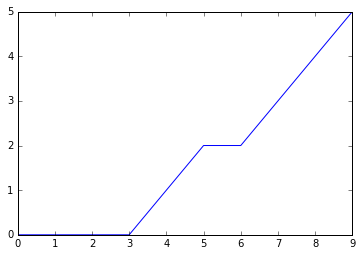

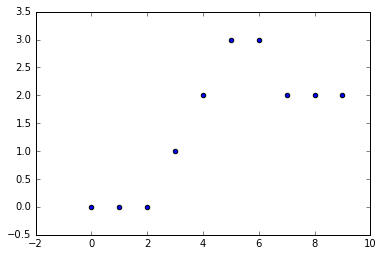

In [4]:
class Player(Bandit):
    def __init__(self, config):
        Bandit.__init__(self, config)
        
    def choose(self):
        return int(input("Enter a number from 0 to " + str(self.n_arms - 1) + ": "))
    
    def learn(self, i_arm, reward):
        print("Your choice is arm: ", i_arm)
        print("Your reward is: ", reward)

    def start(self, arms):
        rounds = int(input("Enter the number of rounds you want to play: "))
        print("Choose the arm you think that will give you more reward", )
        print("from a total number of " + str(self.n_arms) + " arms", )
        for _ in range(rounds):
            self.pull_and_learn(arms)
        
        
player = Player(config)
player.start(arms)
print("Your performence")
player.plot_history()

## Define the Thompson bandit

In [5]:
class Thompson(Bandit):
    def __init__(self, config):
        Bandit.__init__(self, config)
        
        # Define the prior of the Beta distribution
        self.a = np.ones(self.n_arms)
        self.b = np.ones(self.n_arms)
        
    def choose(self):
        guess = np.zeros(self.n_arms)
        for i_arm in range(self.n_arms):
            guess[i_arm] = rand.beta(self.a[i_arm], self.b[i_arm])
        return np.argmax(guess)
    
    def learn(self, i_arm, reward):
        # According to beta posterior update by binomial(n=1) data 
        self.a[i_arm] += reward
        self.b[i_arm] += 1 - reward

[ 0.38994684  0.13741679  0.85902938  0.22821949]


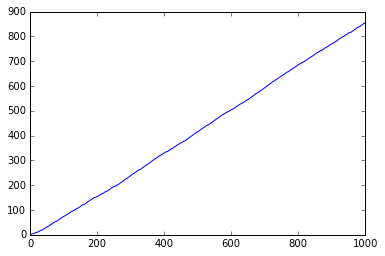

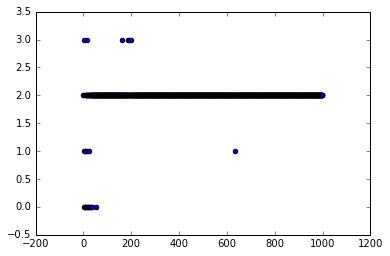

In [6]:
th = Thompson(config)
print(arms.hidden_status)
for _ in range(1000):
    th.pull_and_learn(arms)

th.plot_history()

## Define the UCB1 Bandit

In [12]:
class UCB1(Bandit):
    def __init__(self, config):
        Bandit.__init__(self, config)
        
        # Define time
        self.t = 0
        
        # Record sum of the reward of each arm
        self.sum_reward = np.zeros(self.n_arms)
        
        # Record how many times each arm have been pulled
        self.times_pulled = np.zeros(self.n_arms)
        
    def choose(self):
        if self.t < self.n_arms:
            return self.t
        else:
            guess = np.zeros(self.n_arms)
            for i_arm in range(self.n_arms):
                guess[i_arm] = self.ucb1(i_arm)
            return np.argmax(guess)
        
        
    def ucb1(self, i_arm):
        ave_r = self.sum_reward[i_arm]/self.times_pulled[i_arm]
        return ave_r + np.sqrt(2*np.log(self.t)/self.times_pulled[i_arm])
        
    def learn(self, i_arm, reward):
        # time pass by 
        self.sum_reward[i_arm] += reward
        self.times_pulled[i_arm] += 1
        self.t += 1

[ 0.38994684  0.13741679  0.85902938  0.22821949]


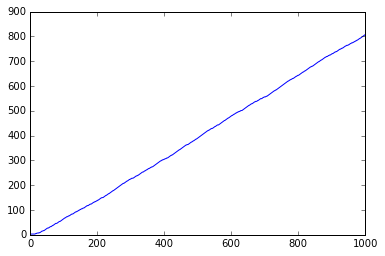

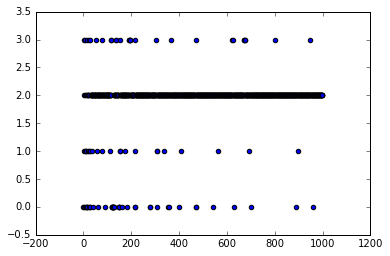

In [13]:
uc = UCB1(config)
print(arms.hidden_status)
for _ in range(1000):
    uc.pull_and_learn(arms)

uc.plot_history()

## Comparison

In [ ]:
th = Thompson(config)
uc = UCB1(config)

for _ in range(1000):
    th.pull_and_learn(arms)
    uc.pull_and_learn(arms)

plt.plot(np.cumsum(th.reward_history))
plt.plot(np.cumsum(uc.reward_history))
plt.show()
#plt.scatter(range(len(self.arm_history)), self.arm_history)
#plt.show()